In [1]:
# STEP 1: Data Acquisition

import os
import pandas as pd
import numpy as np

# Check working directory and CSV availability
print("Notebook working directory:", os.getcwd())
print("CSV exists (relative):", os.path.exists('netflix_titles.csv'))
print("CSV absolute path exists:", os.path.exists('/Users/ragnar/Desktop/PROJET/netflix_titles.csv'))

# Load the dataset (use relative path if available, otherwise fall back to absolute)
try:
    csv_path = 'netflix_titles.csv'
    if not os.path.exists(csv_path):
        csv_path = '/Users/ragnar/Desktop/PROJET/netflix_titles.csv'
    df = pd.read_csv(csv_path)
    print("Dataset loaded successfully.")
    print(f"Dimensions: {df.shape}")
except FileNotFoundError:
    print("Error: 'netflix_titles.csv' not found at either path.")
    df = pd.DataFrame()

# Display first rows to understand structure
df.head()

Notebook working directory: /Users/ragnar/Documents/GitHub/netflixandtvshows
CSV exists (relative): True
CSV absolute path exists: True
Dataset loaded successfully.
Dimensions: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


Data Ready.
Starting detailed evaluation...

================ Logistic Regression ================
Global Accuracy: 0.6551

Classification Report:
              precision    recall  f1-score   support

     General       0.66      0.76      0.71       958
      Mature       0.65      0.53      0.58       802

    accuracy                           0.66      1760
   macro avg       0.65      0.64      0.64      1760
weighted avg       0.65      0.66      0.65      1760



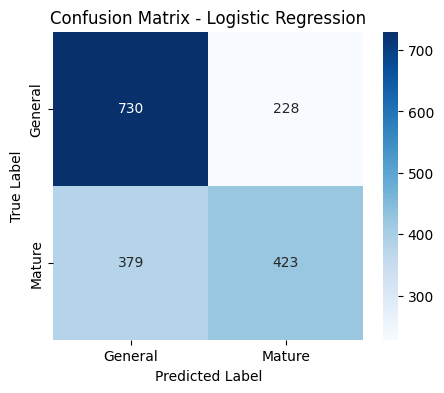



================ Random Forest ================
Global Accuracy: 0.6386

Classification Report:
              precision    recall  f1-score   support

     General       0.64      0.75      0.69       958
      Mature       0.63      0.50      0.56       802

    accuracy                           0.64      1760
   macro avg       0.64      0.63      0.63      1760
weighted avg       0.64      0.64      0.63      1760



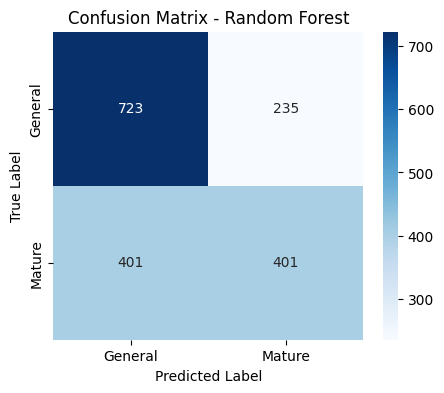



================ SVM ================
Global Accuracy: 0.6352

Classification Report:
              precision    recall  f1-score   support

     General       0.66      0.69      0.67       958
      Mature       0.61      0.57      0.59       802

    accuracy                           0.64      1760
   macro avg       0.63      0.63      0.63      1760
weighted avg       0.63      0.64      0.63      1760



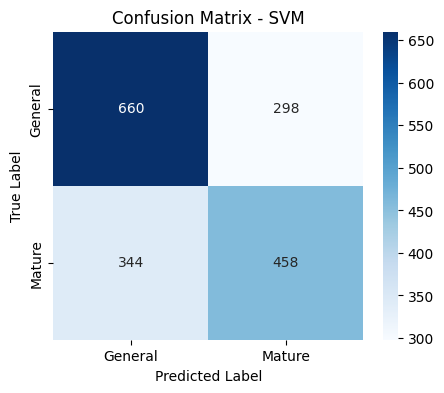



All models evaluated.


In [ ]:
# STEP 5: Model Training & Evaluation (Detailed Version)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


try:
    df = pd.read_csv('netflix_titles.csv')
    valid_ratings = [r for r in df['rating'].unique() if isinstance(r, str) and 'min' not in r]
    df_clean = df[df['rating'].isin(valid_ratings)].copy()
    df_clean.dropna(subset=['rating', 'description'], inplace=True)
    mature_labels = ['TV-MA', 'R', 'NC-17', 'UR']
    df_clean['is_mature'] = df_clean['rating'].apply(lambda x: 1 if x in mature_labels else 0)
    
    X = df_clean['description']
    y = df_clean['is_mature']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Data Ready.")
except Exception as e:
    print(f"Data loading skipped or failed: {e}")


# Pipeline 1: Logistic Regression
pipe_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', LogisticRegression(random_state=42))
])

# Pipeline 2: Random Forest
pipe_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Pipeline 3: SVM
pipe_svm = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', LinearSVC(random_state=42))
])

models = {
    'Logistic Regression': pipe_lr,
    'Random Forest': pipe_rf,
    'SVM': pipe_svm
}


print("Starting detailed evaluation...\n")

for name, model in models.items():
    print(f"================ {name} ================")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # 1. Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Global Accuracy: {acc:.4f}")
    
    # 2. Detailed Report (Precision, Recall, F1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['General', 'Mature']))
    
    # 3. Visual Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['General', 'Mature'], 
                yticklabels=['General', 'Mature'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    print("\n")

print("All models evaluated.")